In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import csv
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"


In [3]:
base_path = r'C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\\'

ids_path = 'prepeard_data2.csv'
vocab_path = "vocab.csv"

data_len = 2231142

In [4]:
with open(base_path + vocab_path, 'r') as file:
    vocab = [t[0] for t in list(csv.reader(file))[1:]]

print(vocab)

['<UKN>', '<PAD>', '.', '*', ',', 'and', 'the', '1', 'to', 'in', 'a', '2', 'with', '1/2', ')', '(', 'of', 'cup', 'until', 'add', 'for', 'or', 'c.', 'minutes', 'salt', 'sugar', 'into', 'on', 'pepper', 'heat', '3', 'teaspoon', 'butter', '1/4', 'chopped', 'oil', 'over', 'mix', 'cheese', 'water', ';', 'tsp', 'flour', 'large', 'cups', '4', 'cream', 'tablespoons', 'cook', 'pan', 'bowl', 'mixture', 'stir', 'about', 'onion', 'sauce', 'at', 'bake', 'baking', 'chicken', 'can', 'place', 'garlic', 'is', 'milk', 'tbsp', 'oven', 'it', 'medium', 'cut', 'top', 'eggs', 'brown', 'juice', 'ingredients', 'from', 'combine', 'pour', 'tablespoon', 'well', 'small', 'fresh', 'egg', 'remove', '5', 'serve', '8', 'then', 'vanilla', 'ground', 'cool', 'oz', 'powder', 'cover', '6', '12', 'you', 'each', 'all', '10', 'together', 'if', 'lemon', 'sliced', 'olive', '3/4', 'remaining', 'teaspoons', 'let', 'boil', 'set', 'lb', 'sprinkle', 'green', 'onions', ':', 'taste', 'are', 'hot', 'dough', 'as', 'red', 'ounces', 'tomat

In [5]:

vocab =  vocab + ["<ING>", "<REC>"]



w2id =  {w:i for i,w in  enumerate(vocab)}
id2w =  {i:w for i,w in  enumerate(vocab)}

(w2id)["<REC>"]

10001

In [6]:

    
class Generator_next_token(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(Generator_next_token, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_layers * hidden_size, output_size)

    def forward(self, input_sequence):
        # input_sequence shape: (batch_size, sequence_length, input_size)
        hidden_states, (h_n, _) = self.rnn(input_sequence)
        # h_n shape: (num_layers, batch_size, hidden_size)

        # Concatenate or stack hidden states from all layers
        h_n_flat = h_n.permute(1, 0, 2).contiguous().view(input_sequence.size(0), -1)
        
        # Pass through the linear layer

        output = self.fc(h_n_flat)
        # output shape: (batch_size, output_size)
        probs = torch.softmax(output, dim = 1)
        return probs, hidden_states

# Example usage
batch_size = 32
sequence_length = 10
input_size = 50
hidden_size = 64
output_size = input_size

# Create an instance of the Generator
generator = Generator_next_token(input_size, hidden_size, output_size, 2)

# Generate a random batch of input sequences
input_sequence = torch.randn(batch_size, sequence_length, input_size)

# Forward pass through the generator
output_vector, _ = generator(input_sequence)

print("Input sequence shape:", input_sequence.shape)
print("Output vector shape:", output_vector.shape)


Input sequence shape: torch.Size([32, 10, 50])
Output vector shape: torch.Size([32, 50])


In [7]:


# Define the Generator
class Generator(nn.Module):
    def __init__(self, vocab_len,hidden_size, depth,max_len):
        super(Generator, self).__init__()
        
        self.embedding = nn.Linear(vocab_len, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=depth, batch_first=True)
        self.hidden2vocab = nn.Linear(hidden_size, vocab_len)
        self.hidden_l = nn.Linear(hidden_size * depth, hidden_size)
        self.max_len = max_len
        

        
        

    def forward(self, input_seq):
        original_input = input_seq.clone()
        sequences = self.embedding(input_seq.float())
        outputs = []
    
        for _ in range(self.max_len):
            last_hidden, hidden_states = self.singel_pass(sequences)
            outputs.append(last_hidden)
            sequences = torch.cat((sequences, last_hidden.unsqueeze(1)), dim = 1)
       
        outputs = torch.stack(outputs, dim = 1)
        vocab_vectors = self.hidden2vocab(outputs)
        vocab_probs = torch.softmax(vocab_vectors, dim=2)
        
        out = torch.concat((original_input,vocab_probs), dim=1)
        return out, hidden_states
            
        

    def singel_pass(self, input_seq):
        rand_source = torch.rand((input_seq.shape[0], 1, input_seq.shape[2])).to(device)
        #embedded = torch.concat((rand_source, embedded), dim = 1)
        hidden_states, (last_hidden, _) = self.rnn(input_seq)
        last_hidden = last_hidden.view(1, -1)
        output = self.hidden_l(last_hidden)
        
        return output, hidden_states


# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, vocab_len, hidden_size):
        super(Discriminator, self).__init__()
        self.embedding = nn.Linear(vocab_len, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, input):
        embedded = self.embedding(input)
        hidden_states, (last_hidden, _) = self.rnn(embedded)
        output = self.fc(last_hidden)
        prob = F.sigmoid(output)
        return prob, hidden_states

In [8]:
class CSVDataLoader:
    def __init__(self, csv_file_path, batch_size, num_rows):
        self.csv_file_path = csv_file_path
        self.batch_size = batch_size
        self.num_rows = num_rows
        self.current_index = 0
        self.file_handle = None
        self.csv_writer = None
        self.headers = None

    def open_csv_file(self):
        self.file_handle = open(self.csv_file_path, 'r', newline='')
        self.csv_writer = csv.reader(self.file_handle)
        # Assuming the first row contains headers
        self.headers = next(self.csv_writer)

    def close_csv_file(self):
        if self.file_handle is not None and not self.file_handle.closed:
            self.file_handle.close()

    def reset(self):
        self.close_csv_file()
        self.open_csv_file()
        self.current_index = 0

    def has_next_batch(self):
        return self.current_index < self.num_rows

    def get_next_batch(self, pad):
        ing_batch = [] 
        rec_batch = []
        for _ in range(self.batch_size):
            if not self.has_next_batch():
                break
            ing, rec = next(self.csv_writer)
            ing_batch.append(torch.tensor(eval(ing)).to(device))
            rec_batch.append(torch.tensor(eval(rec)).to(device))
            self.current_index += 1
       
        

        ing_padded = pad_sequence(ing_batch, batch_first=True, padding_value=pad)
        rec_padded = pad_sequence(rec_batch, batch_first=True, padding_value=pad)
        return ing_padded, rec_padded
    
    def batches_left(self):
        return (self.num_rows - self.current_index) // self.batch_size
    
    def __del__(self):
        self.close_csv_file()

In [9]:
for i in range(1,100,10):
    print(F.normalize(torch.tensor([[0.1,0.2,0.5]], dtype=torch.float32) * i, dim = 1))

tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])


In [10]:
def one_hot_noisify_tokens(batch, vocab_len, temperature, diffrance):
    one_hots = torch.nn.functional.one_hot(batch, vocab_len)
    rands = (torch.rand(one_hots.shape))
    rands[one_hots == 1] = 1 + diffrance
    rands = torch.pow(rands + 0.5, temperature)
    noisified = F.normalize(rands, dim = 2)
    return noisified
def one_hot_stats(batch, hot_batch):
    print("Avreg one hot value:",torch.mean(torch.gather(hot_batch, 2, batch.unsqueeze(-1))).item())
    a = torch.topk(hot_batch, 2, )[0]
    print("Avg first and second eq:", (a[:,:,0]==a[:,:,1]).float().mean().item())
    zero_mask = ~(torch.nn.functional.one_hot(batch, hot_batch.shape[-1])== 1)
    #print("Varaiance", torch.mean(torch.var(hot_batch[zero_mask].view(hot_batch.shape[-1],-1), dim = 1)).item())
    
a = torch.tensor([[0,1,2,3]])
b = one_hot_noisify_tokens(a, 4, 20, 0.001)
one_hot_stats(a,b)
print(b)



Avreg one hot value: 0.9259712100028992
Avg first and second eq: 0.0
tensor([[[9.9969e-01, 1.2755e-02, 2.1367e-02, 1.4638e-08],
         [4.7973e-02, 9.9153e-01, 1.2073e-01, 1.4564e-09],
         [3.0358e-05, 3.7650e-04, 1.0000e+00, 5.0599e-06],
         [6.8660e-06, 6.9824e-01, 6.7543e-02, 7.1267e-01]]])


In [11]:
"""args = torch.randint(1,100, (1000, 3))
r = torch.arange(2500).view(50, -1)
for b,c,d in tqdm(args):
    h = one_hot_noisify_tokens(r, 2500, b,c,30).argmax(dim=2)
    assert(torch.equal(r, h))"""

'args = torch.randint(1,100, (1000, 3))\nr = torch.arange(2500).view(50, -1)\nfor b,c,d in tqdm(args):\n    h = one_hot_noisify_tokens(r, 2500, b,c,30).argmax(dim=2)\n    assert(torch.equal(r, h))'

In [12]:
def patch_batch(ings, start, midel):
    start_tokens = torch.full((ings.shape[0],), start).unsqueeze(1).to(device)
    midel_tokens = torch.full((ings.shape[0],), midel).unsqueeze(1).to(device)
    return torch.cat((start_tokens, ings, midel_tokens), dim=1).to(device)


In [13]:
data_path = r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\prepeard_data.csv"
data_loader = CSVDataLoader(data_path, 32, 2231142)
data_loader.open_csv_file()
d = data_loader.get_next_batch(w2id["<PAD>"])
data_loader.close_csv_file()

patch_batch(d[0], w2id["<ING>"], w2id["<REC>"])[0]

tensor([10000,     3,    67,   206,  1827,    96,     4,    59,   345,     2,
           23,   742,    55,   227,     2,     3,    28,    34,    48,   196,
          103,     2,     3,   483,   117,    34,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1, 10001])

In [14]:
b = patch_batch(d[0], w2id["<ING>"], w2id["<REC>"])
h = one_hot_noisify_tokens(b,len(vocab),
                       50,0.1)
one_hot_stats(b,h)
print(h[1][1][:100])

Avreg one hot value: 0.9002276659011841
Avg first and second eq: 0.0
tensor([3.2040e-16, 9.1229e-11, 4.8201e-07, 3.6635e-16, 6.9511e-04, 8.9700e-01,
        1.8116e-06, 1.0175e-25, 1.7930e-15, 2.1870e-07, 1.2106e-15, 2.0577e-15,
        1.1727e-06, 1.0169e-02, 2.6010e-16, 1.2806e-15, 3.2305e-07, 4.2136e-06,
        2.3936e-14, 9.4822e-24, 6.8434e-12, 1.1593e-24, 1.4781e-04, 3.8896e-07,
        2.7968e-04, 9.5572e-15, 4.3459e-18, 1.1298e-07, 6.3186e-16, 6.1291e-26,
        2.1090e-19, 4.8243e-15, 1.1927e-13, 1.9989e-22, 1.1009e-18, 6.0667e-08,
        1.2323e-21, 1.9187e-08, 2.5275e-13, 2.8096e-15, 1.0558e-10, 1.5650e-19,
        3.0771e-15, 6.2381e-06, 1.7572e-03, 1.3983e-12, 3.1193e-09, 3.9821e-09,
        3.4757e-03, 9.4759e-11, 5.7426e-08, 2.7625e-07, 3.1264e-09, 1.7542e-22,
        1.2691e-21, 3.3527e-08, 7.2618e-09, 1.3357e-14, 3.6791e-05, 3.4955e-07,
        1.0944e-24, 3.9632e-18, 1.1942e-24, 2.1780e-07, 1.2489e-09, 1.5500e-10,
        2.7415e-19, 7.0957e-10, 9.3497e-10, 8.2094e

In [15]:
def topk(next_probs, k):
    topk_values, topk_indices = torch.topk(next_probs, k, dim=1)
    topk_values, topk_indices = topk_values.to(device), topk_indices.to(device)
    topk_index_indices = torch.multinomial(torch.exp(topk_values), 1).squeeze(1).to(device)
    next_tokens = topk_indices[
        torch.arange(topk_index_indices.shape[0]), topk_index_indices]
    return next_tokens

In [16]:
class Dummy_loader:
    def __init__(self, d) -> None:
        self.d = d

    def reset(self):
        pass
    def open_csv_file(self):
        pass
    def batches_left(self):
        return 1

    def get_next_batch(self, a):
        return self.d
    

In [90]:
# Hyperparameters
generator_hidden_size = 100
generator_depth = 10
discriminator_hidden_size = 100
#seq_length = 20  # Adjust based on your prompt length
gen_lr  = 0.1
disc_lr = gen_lr/100
batch_size = 1

k = 1
max_gen_len = 4
epochs = 100



In [102]:
torch.autograd.set_grad_enabled(True)
a = CSVDataLoader(r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\dummy_data.csv", 1, 1)
a.open_csv_file()
pad1 = w2id["<PAD>"]

dummy_loader = Dummy_loader(a.get_next_batch(pad1))
#data_loader = CSVDataLoader(data_path, batch_size, 2231142)


data_loader = dummy_loader


data_loader.open_csv_file()
# Instantiate Generator and Discriminator
generator = Generator_next_token(len(vocab), generator_hidden_size, len(vocab), generator_depth).to(device)
discriminator = Discriminator(len(vocab), discriminator_hidden_size).to(device)


# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=gen_lr)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr)
max_grad_norm = 1.0
#torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_grad_norm)
#torch.nn.utils.clip_grad_norm_(generator.parameters(), max_grad_norm)


gen_losses = []
real_losses = []
fake_losses = []
avg_real = []
avg_fake = []
abs = []


for epoch in tqdm(range(epochs)):
    if epoch == 40:
        pass
    data_loader.reset()
    batch_nr = 0
    total_nr_batches = data_loader.batches_left()
    #total_nr_batches =  100
    itr =(range(total_nr_batches))
    for batch_nr in itr:
        
        # Training the Discriminator
        pad1 = w2id["<PAD>"]
       
   
        real_ingredients, real_recipies = data_loader.get_next_batch(pad1)
        real_patched_ings = patch_batch(real_ingredients, 
                                            w2id["<ING>"],
                                            w2id["<REC>"])
        
        #Generator input does not need to be smoothend
        real_batch_x = torch.concat((torch.nn.functional.one_hot(real_patched_ings, len(vocab)),
                                     torch.nn.functional.one_hot(real_recipies, len(vocab))), dim = 1)

        #Discriminator input does need to be smoothend, but not the ingridients
        real_batch_y = torch.concat(
            (torch.nn.functional.one_hot(real_patched_ings, len(vocab)), 
             one_hot_noisify_tokens(real_recipies, len(vocab), 50, 0.1)),dim=1)
        a = real_batch_y.argmax(dim=2)
        #print(real_batch_y)

        real_batch_x = real_batch_x.float()
        real_batch_y = real_batch_y.float()
        for index in range(real_patched_ings.shape[1],real_batch_x.shape[1]):
            disc_optimizer.zero_grad()
            gen_optimizer.zero_grad()
            sequence_x = real_batch_x[:,:index,:]
            sequence_y = real_batch_y[:,:index+1,:]
             
            generated_token_vectors, _ = generator(sequence_x)
            disc_input = torch.concat((sequence_x,generated_token_vectors.unsqueeze(1)), dim = 1)

            ab = disc_input.argmax(dim=2)
            #print(generated_recepies)
            abs.append([i.item() for i in (ab[0])])
            real_output, _ = discriminator(sequence_y)
            real_output = real_output.squeeze(-1).squeeze(0)
            fake_output, _ = discriminator(disc_input.detach())
            fake_output = fake_output.squeeze(-1).squeeze(0)

            real_labels = torch.ones((batch_size, )).to(device)
            fake_labels = torch.zeros((batch_size, )).to(device)
            real_loss = criterion(real_output, real_labels)
            fake_loss = criterion(fake_output, fake_labels)
            disc_loss = real_loss + fake_loss

            avg_real.append(torch.mean(real_output).item())
            avg_fake.append(torch.mean(fake_output).item())

            
            #print("Disc grad")
            if index == 0 or True:
                disc_loss.backward()
                disc_optimizer.step()
                
            

           
            if avg_fake[-1] <= 0.35 or True:
                 # Training the Generator
                fake_output, _ = discriminator(disc_input)
                fake_output = fake_output.squeeze(-1).squeeze(0)
                real_labels = torch.ones((batch_size, )).to(device)
                gen_loss = criterion(fake_output, real_labels)
                gen_loss.backward()
                gen_optimizer.step()

            gen_losses.append(gen_loss.item())
            real_losses.append(real_loss.item())
            fake_losses.append(fake_loss.item())

    
            

100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


In [103]:
for a in abs:
    print(a[6:])

[6357]
[31, 2482]
[31, 4028, 2482]
[31, 4028, 208, 2482]
[4632]
[31, 2702]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 1606]
[31, 4028, 208, 1606]
[1606]
[31, 1606]
[31, 4028, 16

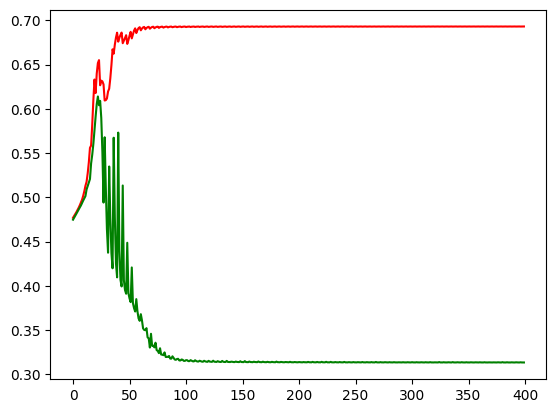

4.9214249884244055e-05

In [104]:
import matplotlib.pyplot as plt
plt.plot(gen_losses, color = "red")
plt.plot(real_losses, color = "green")
plt.show()
avg_fake[-1]

In [88]:
print(gen_losses[-1], real_losses[-1], fake_losses[-1])

0.4790678024291992 0.4791279733181 0.96590256690979


In [89]:
from nltk.tokenize import word_tokenize

In [25]:
def encode(prompt, dic):
    return [dic.get(t.lower(),dic["<UKN>"]) for t in word_tokenize(prompt)]

In [26]:
encode("1. break milk I brew a cool candy", w2id)

[5182, 733, 64, 209, 3877, 10, 90, 855]

In [27]:
def decode(answer, dic):
    return " ".join([dic[i] for i in answer])

In [28]:
decode(encode("we bake a NLP cake", w2id), id2w)

'we bake a <UKN> cake'

In [29]:
def generate(prompt, generator):
    t = torch.tensor(encode(prompt, w2id)).unsqueeze(0).to(device)
    batch = torch.nn.functional.one_hot(patch_batch(t,
                              w2id["<ING>"],
                              w2id["<REC>"]))
    answer, _ = generator(batch)
    ids = answer[0].argmax(dim=1)
    return decode([int(i) for i in ids], id2w)

In [30]:
seed = 1337
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
ing, rec ="1 c. firmly packed brown","In a heavy 2-quart"

generator.eval()
with torch.no_grad():
    print((generate(ing, generator)))
print()
print(rec)

RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float